# Document Embedding Visualization with ChromaDB

This notebook demonstrates how to:
1. Load a PDF document and extract text
2. Chunk the text for embedding
3. Store embeddings in ChromaDB using sentence-transformers
4. Visualize the embedding space in 3D with Plotly

---

## 1. Prerequisites

**Run the setup script before opening this notebook:**

```bash
./setup.sh
```

Then select the **chroma_demo** Jupyter kernel.

**Expected wait times (first run):** Import libraries ~30–60 sec; ChromaDB setup (model load) ~1–2 min.

- **Jupyter Notebook**: `Kernel` → `Change kernel` → `Python (chroma_demo)`
- **JupyterLab**: Click the kernel name (top right) → `Python (chroma_demo)`
- **VS Code**: Click the kernel selector in the top-right → `Python (chroma_demo)`

## 2. Import Libraries

Import all required libraries with error handling. **Note:** The first run can take 30–60 seconds (loading sentence-transformers + PyTorch). If you see an import error, ensure you've selected the **chroma_demo** kernel.

In [1]:
print("Loading libraries (sentence-transformers + PyTorch may take 30–60 sec on first run)...")

def check_environment():
    """Verify we're in the correct environment with required packages."""
    try:
        import chromadb
        import PyPDF2
        import sentence_transformers
        import plotly
        return True
    except ImportError as e:
        print("❌ Import Error: Missing required package.")
        print(f"   Details: {e}")
        print("")
        print("📌 Fix: Run ./setup.sh, then select")
        print("   'Python (chroma_demo)' from Kernel → Change Kernel.")
        return False

if not check_environment():
    raise SystemExit("Please fix the environment and re-run this cell.")

import chromadb
from chromadb.utils import embedding_functions
import PyPDF2
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

print("✅ All libraries imported successfully!")

Loading libraries (sentence-transformers + PyTorch may take 30–60 sec on first run)...
✅ All libraries imported successfully!


## 3. PDF Loading Function

Extract text from a PDF file using PyPDF2. **Place your PDF in this folder** (e.g., `use_2025_budget.pdf`) and set the path in the next cells.

In [2]:
def load_pdf_text(pdf_path: str) -> str:
    """
    Extract all text from a PDF file.
    
    Args:
        pdf_path: Path to the PDF file (e.g., 'use_2025_budget.pdf' or './01-vector-visualise/use_2025_budget.pdf')
    
    Returns:
        Concatenated text from all pages.
    """
    text_parts = []
    with open(pdf_path, 'rb') as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text_parts.append(page.extract_text() or "")
    return "\n".join(text_parts)

print("✅ PDF loading function defined.")

✅ PDF loading function defined.


## 4. Text Chunking Function

Split long documents into smaller chunks (500 characters with 50-character overlap) for better embedding quality. Overlap helps preserve context at chunk boundaries.

In [3]:
def chunk_text(text: str, chunk_size: int = 500, overlap: int = 50) -> list[str]:
    """
    Split text into overlapping chunks.
    
    Args:
        text: Full document text.
        chunk_size: Maximum characters per chunk (default 500).
        overlap: Character overlap between consecutive chunks (default 50).
    
    Returns:
        List of text chunks.
    """
    if not text or not text.strip():
        return []
    chunks = []
    start = 0
    step = chunk_size - overlap
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end].strip()
        if chunk:
            chunks.append(chunk)
        start += step
    return chunks

print("✅ Chunking function defined.")

✅ Chunking function defined.


## 5. ChromaDB Setup

Create the ChromaDB client, collection, and embedding function using **all-MiniLM-L6-v2** (384 dimensions, fast and lightweight). **First run:** model download/load may take 1–2 minutes.

In [4]:
# ChromaDB client (persists to disk in ./chroma_data)
client = chromadb.PersistentClient(path="./chroma_data")

# Embedding function using sentence-transformers (all-MiniLM-L6-v2)
# First run: downloads ~90MB model and loads weights (1–2 min)
print("Loading embedding model (all-MiniLM-L6-v2)...")
ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

# Create or get collection for our document chunks
collection_name = "doc_embeddings"
try:
    collection = client.get_collection(name=collection_name, embedding_function=ef)
    print(f"📂 Using existing collection: {collection_name}")
except Exception:
    collection = client.create_collection(name=collection_name, embedding_function=ef)
    print(f"📂 Created new collection: {collection_name}")

print("✅ ChromaDB setup complete.")

Loading embedding model (all-MiniLM-L6-v2)...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


📂 Created new collection: doc_embeddings
✅ ChromaDB setup complete.


## 6. Main Processing: Load PDF, Chunk, and Add to ChromaDB

**👉 Edit the `PDF_PATH` variable** to point to your PDF file. The example uses `use_2025_budget.pdf` in the same folder.

In [5]:
# ⚠️ EDIT THIS: Path to your PDF file (relative or absolute)
PDF_PATH = "use_2025_budget.pdf"  # e.g., "./01-vector-visualise/use_2025_budget.pdf" if running from repo root

# Load PDF and extract text
full_text = load_pdf_text(PDF_PATH)
print(f"📄 Loaded {len(full_text):,} characters from PDF.")

# Chunk the text (500 chars, 50 overlap)
chunks = chunk_text(full_text, chunk_size=500, overlap=50)
print(f"📦 Created {len(chunks)} chunks.")

# Clear existing data if re-running (optional - comment out to append)
try:
    client.delete_collection(collection_name)
    collection = client.create_collection(name=collection_name, embedding_function=ef)
except Exception:
    pass

# Add chunks to ChromaDB with metadata (chunk index)
ids = [f"chunk_{i}" for i in range(len(chunks))]
metadatas = [{"chunk_index": i, "preview": chunk[:80] + "..." if len(chunk) > 80 else chunk} for i, chunk in enumerate(chunks)]

collection.add(
    documents=chunks,
    ids=ids,
    metadatas=metadatas
)

print(f"✅ Added {len(chunks)} chunks to ChromaDB collection '{collection_name}'.")

📄 Loaded 625,256 characters from PDF.
📦 Created 1390 chunks.
✅ Added 1390 chunks to ChromaDB collection 'doc_embeddings'.


## 7. Plotly 3D Visualization

PCA reduces embeddings to 3D; points are coloured by position in the document. Hover over points to see chunk previews.

In [7]:
# Fetch all embeddings and metadata from ChromaDB
results = collection.get(include=["embeddings", "documents", "metadatas"])
embeddings = np.array(results["embeddings"])
documents = results["documents"]
metadatas = results["metadatas"] or [{}] * len(documents)

# PCA: reduce 384 dimensions to 3 for visualization
pca = PCA(n_components=3)
reduced = pca.fit_transform(embeddings)

# Build DataFrame for Plotly
df = pd.DataFrame({
    "x": reduced[:, 0],
    "y": reduced[:, 1],
    "z": reduced[:, 2],
    "chunk_index": [m.get("chunk_index", i) for i, m in enumerate(metadatas)],
    "preview": [doc[:100] + "..." if len(doc) > 100 else doc for doc in documents],
})

# Interactive 3D scatter — colour by chunk position (Turbo gradient)
fig = px.scatter_3d(
    df, x="x", y="y", z="z",
    color="chunk_index",
    color_continuous_scale="Turbo",
    hover_data=["chunk_index", "preview"],
    title="Document Chunk Embeddings (PCA 3D)",
    labels={"x": "PC1", "y": "PC2", "z": "PC3", "chunk_index": "Chunk"},
)
fig.update_traces(marker=dict(size=5, opacity=0.85, line=dict(width=0)))
fig.update_layout(
    template="plotly_white",
    height=650,
    coloraxis_colorbar=dict(title="Chunk index"),
    scene=dict(
        bgcolor="rgb(248, 248, 252)",
        xaxis=dict(gridcolor="lightgray"),
        yaxis=dict(gridcolor="lightgray"),
        zaxis=dict(gridcolor="lightgray"),
    ),
)
fig.show()

print("✅ Plotly 3D visualization complete. Hover over points to see chunk previews.")

ERROR: Could not find a version that satisfies the requirement chromaviz (from versions: none)
ERROR: No matching distribution found for chromaviz
Note: you may need to restart the kernel to use updated packages.


⚠️ ChromaViz not installed. Run: pip install chromaviz
   Falling back to Plotly visualization in the next cell.


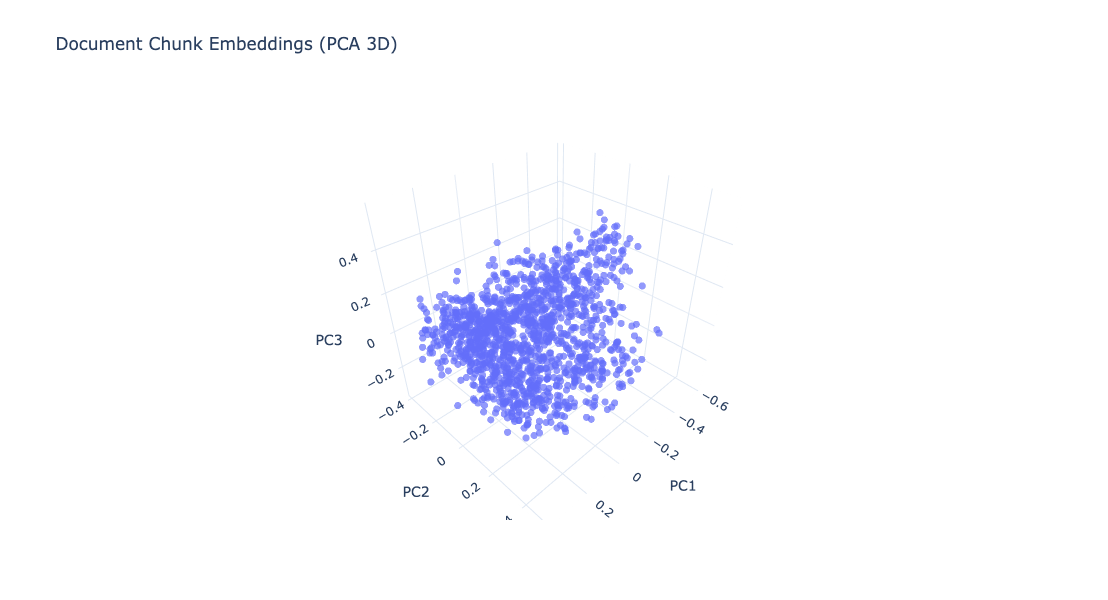

✅ Plotly 3D visualization complete. Hover over points to see chunk previews.
